In [75]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
import plotnine as p9
from mizani.transforms import modulus_trans 

## 14.2: Ridge Regression 

In [5]:
# Read the data
ames = pd.read_csv(r"https://www.dropbox.com/scl/fi/g0n5le5p6fr136ggetfsf/AmesHousing.csv?rlkey=jlr9xtz1o6u5rghfo29a5c02f&dl=1")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [6]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [13]:
pipe1_score = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = "r2").max()
pipe1_score

np.float64(0.9103825305236137)

In [7]:
lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("Ridge", Ridge(alpha = 1))]
)

In [14]:
pipe2_score = cross_val_score(lr_pipeline_2, X, y, cv = 5, scoring = "r2").max()
pipe2_score

np.float64(0.9174402390670319)

In [12]:
max(pipe1_score, pipe2_score)

np.float64(0.9174402390670319)

The results of our cross validation indicate that the model using ridge regression performed better than the one that used ols, although the difference between the two models is very slight. 

In [ ]:
lr_fitted1 = lr_pipeline_1.fit(X, y)
xvals_1 = lr_fitted1.named_steps["linear_regression"].coef_

In [ ]:
lr_fitted2 = lr_pipeline_2.fit(X,y)
xvals_2 = lr_fitted2.named_steps["Ridge"].coef_

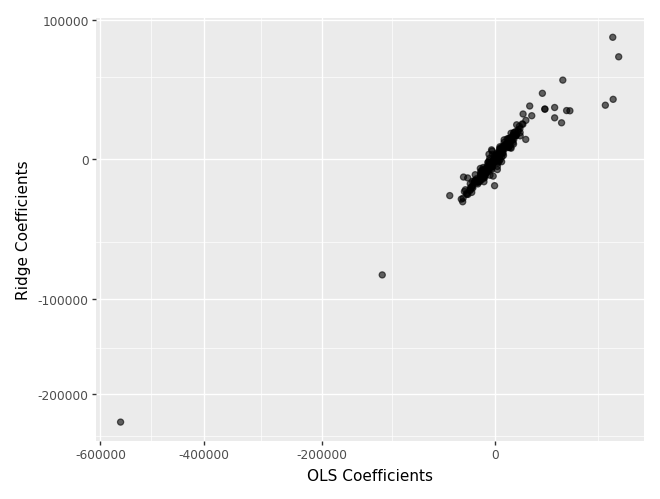

In [73]:
(p9.ggplot(p9.aes(xvals_1, xvals_2))
+p9.scale_x_continuous(trans=modulus_trans(0.75))
+p9.scale_y_continuous(trans=modulus_trans(0.75))
+p9.xlab("OLS Coefficients")
+p9.ylab("Ridge Coefficients")
+p9.geom_point(size = 2, alpha = 0.6)
)

## 14.2.1: Testing Lambdas on log scale

In [76]:
param_grid1 = {'Ridge__alpha': [0.001, 0.01, 0.1, 1, 10]}

grid_search1 = GridSearchCV(estimator = lr_pipeline_2,
                           param_grid = param_grid1,
                           cv=5, 
                           scoring='r2')

In [78]:
fitted_grid1 = grid_search1.fit(X, y)

In [85]:
models_fitted = pd.DataFrame(data = {"alphas":fitted_grid1.cv_results_["params"],
                                    "scores": fitted_grid1.cv_results_['mean_test_score']})
models_fitted

,alphas,scores
0,{'Ridge__alpha': 0.001},0.853920
1,{'Ridge__alpha': 0.01},0.854186
2,{'Ridge__alpha': 0.1},0.856302
3,{'Ridge__alpha': 1},0.861932
4,{'Ridge__alpha': 10},0.864272


In [97]:
lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha = 1))]
)

param_grid2 = {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

grid_search2 = GridSearchCV(estimator = lr_pipeline_3,
                           param_grid = param_grid2,
                           cv=5, 
                           scoring='r2')

In [88]:
fitted_grid2 = grid_search2.fit(X, y)

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

In [91]:
models_fitted2 = pd.DataFrame(data = {"alphas":fitted_grid2.cv_results_["params"],
                                    "scores": fitted_grid2.cv_results_['mean_test_score']})
models_fitted2

,alphas,scores
0,{'Lasso__alpha': 0.001},0.855499
1,{'Lasso__alpha': 0.01},0.855606
2,{'Lasso__alpha': 0.1},0.856618
3,{'Lasso__alpha': 1},0.857152
4,{'Lasso__alpha': 10},0.860632


In [92]:
lr_fitted3 = lr_pipeline_3.fit(X,y)
xvals_3 = lr_fitted3.named_steps["Lasso"].coef_

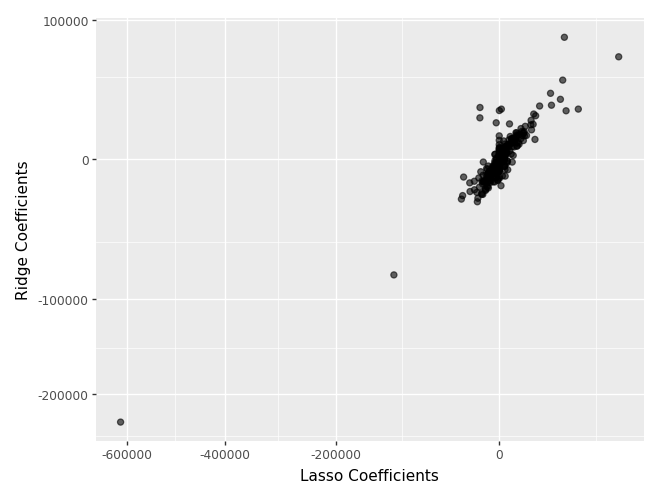

In [93]:
(p9.ggplot(p9.aes(xvals_3, xvals_2))
+p9.scale_x_continuous(trans=modulus_trans(0.75))
+p9.scale_y_continuous(trans=modulus_trans(0.75))
+p9.xlab("Lasso Coefficients")
+p9.ylab("Ridge Coefficients")
+p9.geom_point(size = 2, alpha = 0.6)
)

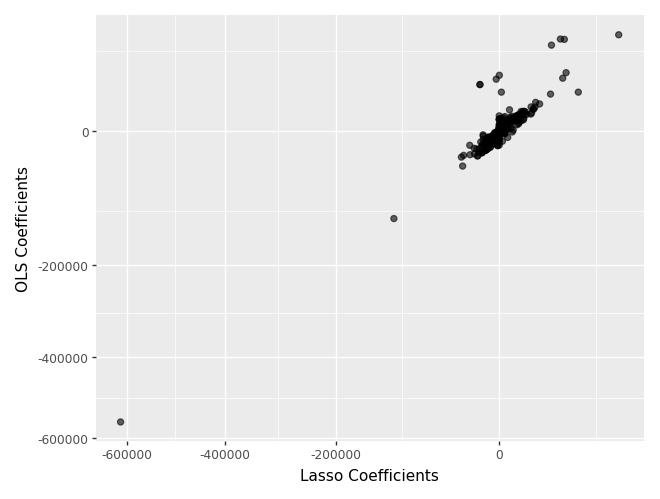

In [94]:
(p9.ggplot(p9.aes(xvals_3, xvals_1))
+p9.scale_x_continuous(trans=modulus_trans(0.75))
+p9.scale_y_continuous(trans=modulus_trans(0.75))
+p9.xlab("Lasso Coefficients")
+p9.ylab("OLS Coefficients")
+p9.geom_point(size = 2, alpha = 0.6)
)

In [98]:
lr_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha=1, l1_ratio=0.5))]
)

param_grid3 = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
              "elastic_net__l1_ratio": np.arange(0.0, 1.2, 0.2)}

grid_search3 = GridSearchCV(estimator = lr_pipeline_4,
                           param_grid = param_grid3,
                           cv=5, 
                           scoring='r2')

In [99]:
lr_fitted4 = lr_pipeline_4.fit(X,y)
xvals_4 = lr_fitted4.named_steps["elastic_net"].coef_

In [100]:
fitted_grid3 = grid_search3.fit(X, y)

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\ldc

In [105]:
models_fitted3 = pd.DataFrame(data = {"alphas":fitted_grid3.cv_results_["params"],
                                    "scores": fitted_grid3.cv_results_['mean_test_score']})

print(models_fitted3.loc[models_fitted3["scores"].idxmax(), "alphas"])
models_fitted3.loc[models_fitted3["scores"].idxmax(), "scores"]

{'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': np.float64(0.6000000000000001)}


np.float64(0.8642599524619167)

In [106]:
xvals_4 = lr_fitted4.named_steps["elastic_net"].coef_

In [120]:
coef_df = pd.DataFrame(data = {"OLS_Coef": xvals_1, 
                     "Ridge_Coef": xvals_2, 
                     "Lasso_Coef": xvals_3, 
                     "Elastic_net_Coef": xvals_4})
coef_df

,OLS_Coef,Ridge_Coef,Lasso_Coef,Elastic_net_Coef
0,-4648.554959,-5585.147072,-4816.528388,-141.971922
1,1546.687999,1279.599730,1227.244385,349.433582
2,-7516.051924,-5465.717759,-4418.855409,-20.358041
3,7867.442231,7876.141644,7519.825758,-55.085186
4,3774.440540,3046.095382,3532.939294,1192.787937
...,...,...,...,...
249,2670.612233,2913.671195,2661.805011,2597.362546
250,2776.215267,1415.145831,2754.158651,99.688526
251,-5139.727420,-4409.406398,-5108.659969,-3157.504796
252,-774.812417,-724.796932,-774.503204,-78.137778
